# Customers and Products Analysis 

# Index

- [Introduction](#1)
- [Exploring the Data](#2)
- [Questions](#3)
- [Profit and Supply](#4)
- [Customer Loyalty](#5)
- [Profits Earned](#6)
- [Best & Worst Product Lines](#7)
- [Monthly Profits Performance](#8)
- [Salesmen Perfomance](#9)
- [New Clients](#10)
- [Dead Stock](#11)
- [Recommendations](#12)
- [Conclusion](#13)

# 1

## Introduction

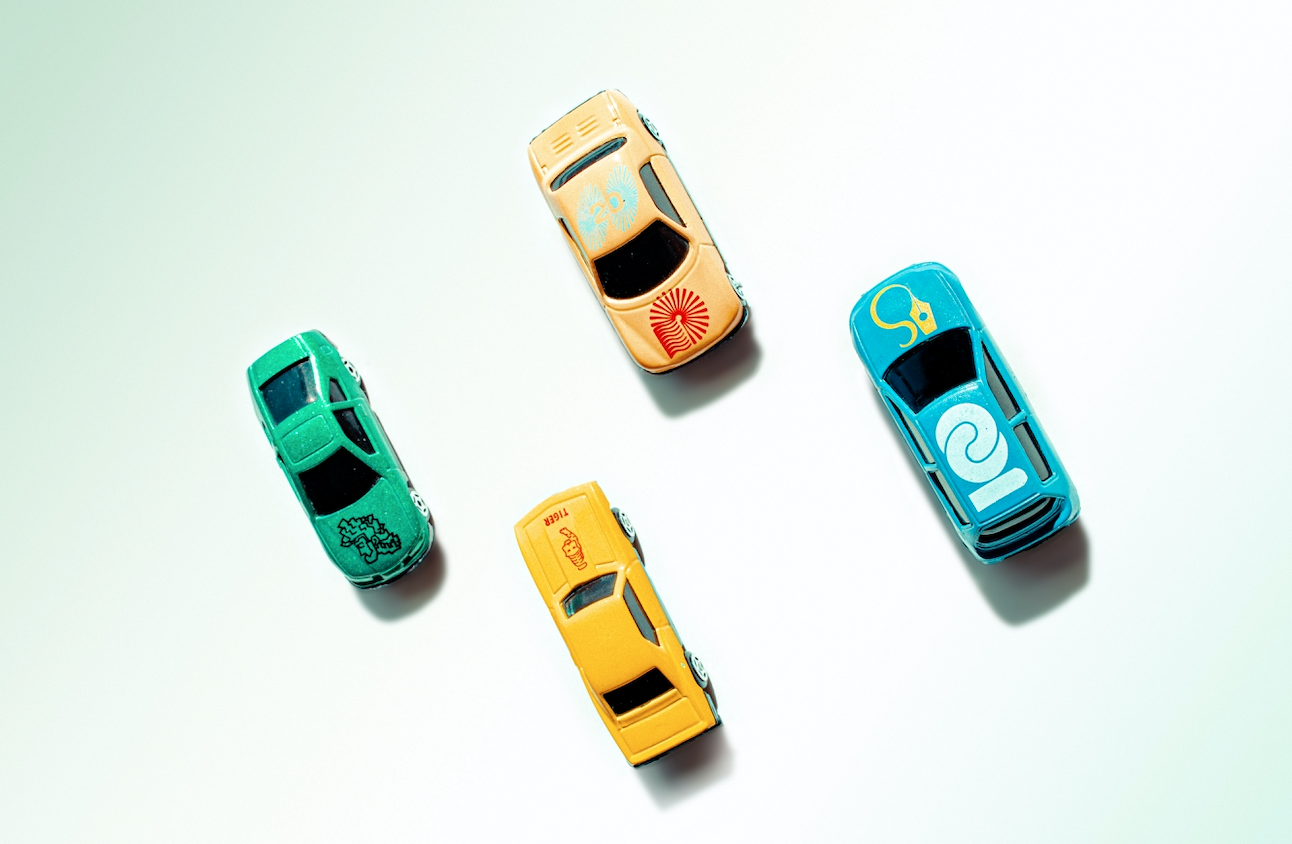

*Source*: [Unsplash](https://unsplash.com/photos/Xxg-r574pLE)

***Vehicle Models Company*** is a hypothetical wholesale distributor of die cast models of vehicles ranging from classic automobiles to aircraft. They have clients in over 15 countries worldwide.

The company has asked me to review and analyze its dataset in order to make some critical decisions about potential future expansion. This project's purpose is to go over the concerns they have and extract solutions based on the data.

It should be mentioned that the organization has allowed me to make assumptions because they do not have people that can address the concerns and questions. I've been told that clarification (on my assumptions) will be provided once the initial report is completed.

[Index](#Index)

# 2

## Exploring the Data

The dataset is accessible [here](https://github.com/ElizavetaGorelova/DataAnalysis_Projects/blob/main/Customers%20and%20Products%20Analysis/vehicle_model.db).
The database schema is presented below.

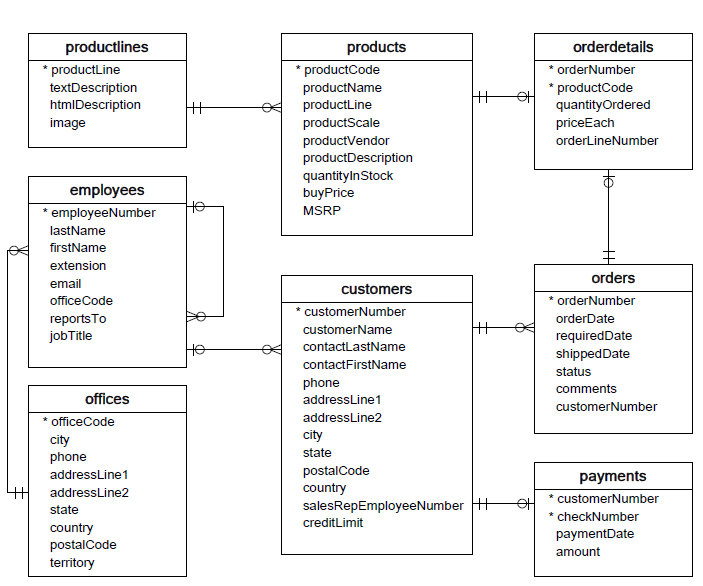

In [1]:
%%capture
%load_ext sql
%sql sqlite:///stores.db

Before analyzing the database, let's first describe it.

In [2]:
%%sql
SELECT '' AS Table_Name,'' AS Number_of_Attributes,'' AS Number_of_Rows
UNION ALL
SELECT 'customer',13,(SELECT COUNT(*)
                        FROM customers)
UNION ALL
SELECT 'products',9,(SELECT COUNT(*)
                        FROM products)
UNION ALL
SELECT 'productlines',4,(SELECT COUNT(*)
                        FROM productlines)
UNION ALL
SELECT 'orders',7,(SELECT COUNT(*)
                        FROM orders)
UNION ALL
SELECT 'orderdetails',5,(SELECT COUNT(*)
                        FROM orderdetails)
UNION ALL
SELECT 'payments',4,(SELECT COUNT(*)
                        FROM payments)
UNION ALL
SELECT 'employees',8,(SELECT COUNT(*)
                        FROM employees)
UNION ALL
SELECT 'offices', 9, (SELECT COUNT(*)
                         FROM offices)

 * sqlite:///stores.db
Done.


Table_Name,Number_of_Attributes,Number_of_Rows
,,
customer,13,122
products,9,110
productlines,4,7
orders,7,326
orderdetails,5,2996
payments,4,273
employees,8,23
offices,9,7


In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('stores.db')
df = pd.read_sql_query("""SELECT * 
                            FROM offices;""", conn)
df

/Users/elizavetagorelova/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,officeCode,city,phone,addressLine1,addressLine2,state,country,postalCode,territory
0,1,San Francisco,+1 650 219 4782,100 Market Street,Suite 300,CA,USA,94080,NA
1,2,Boston,+1 215 837 0825,1550 Court Place,Suite 102,MA,USA,02107,NA
2,3,NYC,+1 212 555 3000,523 East 53rd Street,apt. 5A,NY,USA,10022,NA
3,4,Paris,+33 14 723 4404,43 Rue Jouffroy D'abbans,None,None,France,75017,EMEA
4,5,Tokyo,+81 33 224 5000,4-1 Kioicho,None,Chiyoda-Ku,Japan,102-8578,Japan
5,6,Sydney,+61 2 9264 2451,5-11 Wentworth Avenue,Floor #2,None,Australia,NSW 2010,APAC
6,7,London,+44 20 7877 2041,25 Old Broad Street,Level 7,None,UK,EC2N 1HN,EMEA


The company has several offices, each with multiple employees. Every customer is assigned to a sales representative, whose employee ID is documented in the ```customers``` table, in ```salesRepEmployeeNumber``` column.

The company offers a large number of items that are classified into product lines. Every incoming order contains order-specific information about a product, which is stored in the ```orderdetails``` database. Orders connected with items in the ```orderdetails``` table are tracked separately in the ```orders``` table. 

Customers seem to pay for their items in a cumulative manner after they're shipped out. Customers can also choose to use credit cards since I can see the ```creditLimit``` column in the ```customers``` table. While reviewing the ```orders``` table's ```comments``` column, it was noticed that an order can be placed on hold if a user has exceeded their credit limit for a certain order. Only after the payment has been received, the order is processed.

The ```status``` column in the ```orders``` table tracks the progress of the order from the time it is received to the time it is shipped out.  The various stages of orders' status will be described below.

In [4]:
%%sql
SELECT status AS Order_Status, COUNT(status) AS Number_of_Orders
FROM orders
GROUP BY Order_Status
ORDER BY Number_of_Orders DESC;

 * sqlite:///stores.db
Done.


Order_Status,Number_of_Orders
Shipped,303
In Process,6
Cancelled,6
Resolved,4
On Hold,4
Disputed,3


Let's only analyze orders that have shipped because all other ones require payment confirmation. ```orders``` and ```orderdetails``` related to shipped orders need to be filtered out.

In [5]:
%%sql
DROP VIEW shipped_orders;
print()

 * sqlite:///stores.db
Done.
(sqlite3.OperationalError) near "print": syntax error
[SQL: print()]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [6]:
%%sql
--# create view to filter only shipped orders with status 'shipped'
CREATE VIEW shipped_orders AS
SELECT orders.*,
       ROUND(SUM(orderdetails.quantityOrdered * orderdetails.priceEach), 2) AS Order_Total,
       ROUND(SUM((orderdetails.priceEach - products.buyPrice) * orderdetails.quantityOrdered), 2) AS Order_Profit
FROM orders
JOIN orderdetails
  ON orders.orderNumber = orderdetails.orderNumber
JOIN products
  ON orderdetails.productCode = products.productCode
GROUP BY orders.orderNumber
HAVING status = 'Shipped';

SELECT *
FROM shipped_orders
LIMIT 5;

 * sqlite:///stores.db
Done.
Done.


orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber,Order_Total,Order_Profit
10100,2003-01-06,2003-01-13,2003-01-10,Shipped,None,363,10223.83,3940.36
10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128,10549.01,5236.74
10102,2003-01-10,2003-01-18,2003-01-14,Shipped,None,181,5494.78,2135.94
10103,2003-01-29,2003-02-07,2003-02-02,Shipped,None,121,50218.95,18827.11
10104,2003-01-31,2003-02-09,2003-02-01,Shipped,None,141,40206.2,15680.8


In [7]:
%%sql
--# filter shipped orders' details
SELECT *
FROM orderdetails
WHERE orderNumber IN (SELECT orderNumber
                      FROM shipped_orders)
LIMIT 5;

 * sqlite:///stores.db
Done.


orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber
10100,S18_1749,30,136,3
10100,S18_2248,50,55.09,2
10100,S18_4409,22,75.46,4
10100,S24_3969,49,35.29,1
10101,S18_2325,25,108.06,4


After sorting the ```orders``` and ```orderdetails``` depending on the order ```status```, let's look into the questions that Vehicles Models Company has.

[Index](#Index)

# 3

## Questions
**Addressing the questions raised by Vehicles Models Company**

I was asked to provide responses to the following:

1. Identify the top 10 models that are sold the most.
2. Identify the top 5 customers.
3. Which countries should we concentrate our marketing efforts in order to maximize our profits?
4. Identify the best and worst categories for each country.
5. Determine the sales performance over the entire sales period.
6. We want to grow our sales staff, but we need to know how our present sales team is performing.
7. Should we prioritize acquiring new consumers or engaging our existing customers in order to grow sales?
8. Is there anything in our inventory that hasn't sold in a long time?

Each of these questions is obviously indirect and requires a number of assumptions. As previously said, I will make evaluations and answer these questions based on assumptions because I have complete control over the situation.

[Index](Index)

# 4

## Profit and Supply
**Determining Products with High Demand and High Selling Value**

The first question is about identifying items that are in great demand and are extremely profitable for the company. Stocking up on these items will ensure that the company can meet market demands while also making some extra revenue.

The client has given formulas that we are supposed to use to identify items that are currently in short supply as well as those with higher sale power.

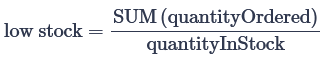

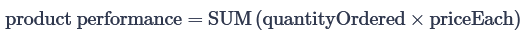

In [8]:
%%sql
WITH
--# ten most popular products
get_lowstock AS(
SELECT productCode,
       --# implementing low stock formula
       (SUM(od.quantityOrdered) * 1.0) / 
                       (SELECT quantityInStock
                        FROM products
                        WHERE od.productCode = productCode) AS low_stock
FROM shipped_order_details od
GROUP BY productCode
ORDER BY low_stock DESC
LIMIT 10
)

SELECT products.productName AS Model_Name,
       products.quantityInStock AS Quantity_on_Hand,
       COUNT(*) AS No_of_Orders, SUM(shipped_order_details.quantityOrdered) AS Total_Quantity_Ordered,
    --# implementing product performance formula
       ROUND(SUM(shipped_order_details.quantityOrdered * shipped_order_details.priceEach), 2) AS Total_Sales, products.productLine AS Prouct_Line
FROM shipped_order_details
JOIN products
  ON products.productCode = shipped_order_details.productCode
WHERE shipped_order_details.productCode IN (SELECT productCode
                                            FROM get_lowstock)
GROUP BY products.productCode
ORDER BY Total_Sales DESC
LIMIT 10;

 * sqlite:///stores.db
Done.


Model_Name,Quantity_on_Hand,No_of_Orders,Total_Quantity_Ordered,Total_Sales,Prouct_Line
1968 Ford Mustang,68,26,909,157749.08,Classic Cars
1928 Mercedes-Benz SSK,548,26,813,121946.96,Vintage Cars
1997 BMW F650 ST,178,26,920,81440.8,Motorcycles
2002 Yamaha YZR M1,600,27,992,73670.64,Motorcycles
1960 BSA Gold Star DBD34,15,28,1015,67193.49,Motorcycles
F/A 18 Hornet 1/72,551,24,872,63905.6,Planes
1928 Ford Phaeton Deluxe,136,25,846,52518.05,Vintage Cars
1996 Peterbilt 379 Stake Bed with Outrigger,814,26,895,52046.16,Trucks and Buses
1911 Ford Town Car,540,22,709,38730.32,Vintage Cars
Pont Yacht,414,22,770,38061.72,Ships


Undoubtedly, the **2001 Ferrari Enzo** is the model that is in high demand and in short supply. Its prospective sale price is also pretty appealing. Aside from the Ferrari model, there are a few other models that require additional orders due to their potential sales worth.

Another observation from the above analysis is that the **Classic Cars** product line appears to be the most popular.

[Index](#Index)

# 5

## Customer Loyalty
**Determining the Most Engaged and Least Engaged Customers**

The second task assigned is to determine the most loyal clients. Vehicle Models has 122 clients. The top five **engaged clients** will be defined as those who have generated the greatest profit for the company through shipped orders.

In [9]:
%%sql
DROP VIEW customer_profit_report;
print()

 * sqlite:///stores.db
Done.
(sqlite3.OperationalError) near "print": syntax error
[SQL: print()]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [10]:
%%sql
CREATE VIEW customer_profit_report AS
SELECT shipped_orders.customerNumber AS customer_id,
       ROUND(SUM(shipped_order_details.quantityOrdered * (shipped_order_details.priceEach - products.buyPrice)), 2) AS profit,
       COUNT(*) AS no_of_orders
FROM shipped_orders
JOIN shipped_order_details
  ON shipped_order_details.orderNumber = shipped_orders.orderNumber
JOIN products
  ON shipped_order_details.productCode = products.productCode
GROUP BY shipped_orders.customerNumber;

SELECT customers.contactLastName||", "||customers.contactFirstName AS Name,
    customers.city AS City,
    customers.country AS Country,
    customer_profit_report.profit AS Profit
FROM customers
JOIN customer_profit_report
  ON customers.customerNumber = customer_profit_report.customer_id
WHERE customer_profit_report.customer_id IN (SELECT customer_id
                                             FROM customer_profit_report
                                             ORDER BY profit DESC
                                             LIMIT 5)
ORDER BY customer_profit_report.profit DESC;

 * sqlite:///stores.db
Done.
Done.


Name,City,Country,Profit
"Freyre, Diego",Madrid,Spain,263439.51
"Nelson, Susan",San Rafael,USA,232494.29
"Young, Jeff",NYC,USA,72370.09
"Ferguson, Peter",Melbourne,Australia,70311.07
"Natividad, Eric",Singapore,Singapore,60477.38


Given that we have the top five clients, we should also consider the top five clients who are the **least engaged** with the business.

In [11]:
%%sql
SELECT customers.contactLastName||", "||customers.contactFirstName AS Name,
    customers.city AS City,
    customers.country AS Country,
    customer_profit_report.profit AS Profit
FROM customers
JOIN customer_profit_report
  ON customers.customerNumber = customer_profit_report.customer_id
WHERE customer_profit_report.customer_id IN (SELECT customer_id
                                             FROM customer_profit_report
                                             ORDER BY profit ASC
                                             LIMIT 5)
ORDER BY customer_profit_report.profit;

 * sqlite:///stores.db
Done.


Name,City,Country,Profit
"Young, Mary",Glendale,USA,2610.87
"Taylor, Leslie",Brickhaven,USA,6586.02
"Mendel, Roland",Graz,Austria,8473.59
"Ricotti, Franco",Milan,Italy,9532.93
"Schmitt, Carine",Nantes,France,10063.8


[Index](#Index)

# 6

## Profits Earned
**Analysing Profits Earned by Country**

Marketing is an expensive investment, so it's better to  determine which markets will benefit the most. In addition to engaging clients, the company should be able to attract high-value customers in order to boost their revenues. Since no parameters have been specified, let's attempt to determine potential markets based on existing customers and sales made to date.

Thd parameters:
- The number of clients in each country.
- The percentage of profit provided by each country to the overall time period for which we have sales data.
- The profit earned by each client of current customer countries.

This analysis should help to determine which countries to target for marketing in order to boost earnings.

In [12]:
%%sql
SELECT customers.country AS Country,
    COUNT(*) AS Number_of_Customers,
    ROUND(SUM(customer_profit_report.profit), 2) AS Profit,
    ROUND(SUM(customer_profit_report.profit) / COUNT(*), 2) AS Profit_Per_Customer,
    ROUND((SUM(customer_profit_report.profit) * 100.0 / (SELECT SUM(profit)
                                                         FROM customer_profit_report)), 2) AS Profit_Percentage
FROM customers
JOIN customer_profit_report
  ON customers.customerNumber = customer_profit_report.customer_id
GROUP BY customers.country
ORDER BY Profit DESC;

 * sqlite:///stores.db
Done.


Country,Number_of_Customers,Profit,Profit_Per_Customer,Profit_Percentage
USA,35,1214220.48,34692.01,34.32
France,12,397728.61,33144.05,11.24
Spain,5,376924.39,75384.88,10.66
Australia,5,201879.08,40375.82,5.71
New Zealand,4,165096.92,41274.23,4.67
UK,5,155313.0,31062.6,4.39
Italy,4,144459.86,36114.97,4.08
Finland,3,117239.33,39079.78,3.31
Singapore,2,101782.55,50891.28,2.88
Canada,3,78858.78,26286.26,2.23


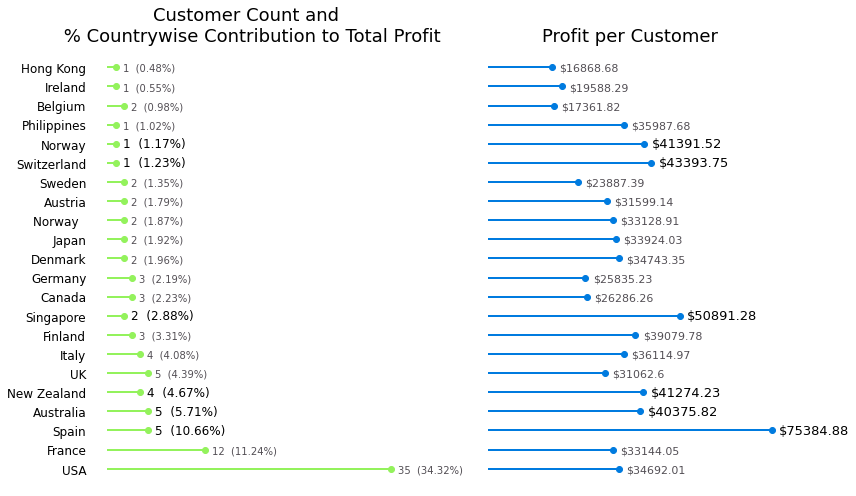

In [13]:
global_profit_report = pd.read_sql_query(
"""SELECT customers.country AS Country,
     COUNT(*) AS Number_of_Customers,
     ROUND(SUM(customer_profit_report.profit), 2) AS Profit,
     ROUND(SUM(customer_profit_report.profit) / COUNT(*), 2) AS Profit_Per_Customer,
     ROUND((SUM(customer_profit_report.profit) * 100.0 / (SELECT SUM(profit)
                                                          FROM customer_profit_report)), 2) AS Profit_Percentage
   FROM customers
   JOIN customer_profit_report
     ON customers.customerNumber = customer_profit_report.customer_id
   GROUP BY customers.country
   ORDER BY Profit DESC;""", conn
)

fig = plt.figure(figsize=(12, 7))

# plot the customer count and profit earned in each country
ax1 = fig.add_subplot(1, 2, 1)
 
# remove spines
for key in ax1.spines.keys():
    ax1.spines[key].set_visible(False)
    
# plot customer count
ax1.hlines(y = global_profit_report['Country'],
           xmin = 0,
           xmax = global_profit_report['Number_of_Customers'],
           color = '#93f25c',
           linewidth=2)
ax1.scatter(y = global_profit_report['Country'],
            x = global_profit_report['Number_of_Customers'],
            color = '#93f25c')

# modify plot
ax1.tick_params(axis = 'y', left = False, labelsize = 12)
ax1.tick_params(axis = 'x', bottom = False, labelbottom = False)

# specific values for annotation
big_spend_countries = [global_profit_report.iloc[i, 0] for i in range(len(global_profit_report)) if global_profit_report.iloc[i, 3] > 40000]
size = [12 if global_profit_report.iloc[i, 0] in big_spend_countries else 10 for i in range(len(global_profit_report))]
palette = ['black' if global_profit_report.iloc[i, 0] in big_spend_countries else '#524e54' for i in range(len(global_profit_report))]

# general annotations
for i in range(len(global_profit_report)):
    ax1.text(s = str(global_profit_report.iloc[i, 1])+'  '+'('+str(global_profit_report.iloc[i,4])+'%'+')',
             x = global_profit_report.iloc[i,1] + 0.9,
             y = i - 0.2,
             size = size[i],
             color = palette[i])
ax1.set_title('Customer Count and \n % Countrywise Contribution to Total Profit', size = 18, loc = 'center')

#---------------------#

# plot profit per customer
ax2 = fig.add_subplot(1, 2, 2)

# remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)
    
# plot profit per customer
ax2.hlines(y = global_profit_report['Country'],
           xmin = 0,
           xmax = global_profit_report['Profit_Per_Customer'],
           color = '#007bdf',
           linewidth = 2)
ax2.scatter(y = global_profit_report['Country'],
            x = global_profit_report['Profit_Per_Customer'],
            color = '#007bdf')

# modify plot
ax2.tick_params(axis = 'y', left = False, labelsize = 14, labelleft = False)
ax2.tick_params(axis = 'x', bottom = False, labelbottom = False)

# specific values for annotation
size = [13 if global_profit_report.iloc[i, 3] > 40000 else 11 
        for i in range(len(global_profit_report))]
palette = ['black' if global_profit_report.iloc[i, 3] > 40000 else '#524e54' 
           for i in range(len(global_profit_report))]

# general annotations
for i in range(len(global_profit_report)):
    ax2.text(s ='$' + str(global_profit_report.iloc[i,3]),
             x = global_profit_report.iloc[i,3] + 2000,
             y = i-0.2,
             size = size[i],
             color = palette[i])
ax2.set_title('Profit per Customer', size = 18, loc = 'center')

#---------------------#

plt.tight_layout()
plt.show()
plt.rcParams['figure.dpi'] = 300

**Insights:**

After looking at the visualization, I can conclude that clients from ***Spain*** generate more profits than most customers.

- Undoubtedly, interest in model cars stands out in countries such as the United States and France (particularly more in the USA than in France).
- There are other countries of interest, such as Spain, Australia, and Norway, that have very few consumers yet account for significant customer expenditure.
- Australia, the United Kingdom, and France each have zonal offices that oversee more than four clients in their respective regions. Despite having a zonal office in Tokyo, Japan has only two clients though.
- The Asian market is underrepresented, with only 5 clients from three countries: Japan, Singapore, and the Philippines.
- South American and African countries are completely absent.
- Surprisingly, while the United States is a significant market, clients in Spain, Singapore, and New Zealand spend more than those in the USA.

[Index](#Index)

# 7

## Best & Worst Product Lines
**The Best and Worst Product Lines in Various Countries**

The company has asked to determine the best and worst performing product lines in each of the countries from where their customers originate.

There's lack of information on the criteria for judging the best and worst product lines. So let's just go with the number of the product line being purchased, and then determine which product lines are the best and worst in each country based on the representation of the product lines in the order details.

In [14]:
%%sql
WITH
--# join orderdetails and products
order_category AS(
SELECT orderdetails.orderNumber, products.productLine
FROM products
JOIN orderdetails
  ON products.productCode = orderdetails.productCode
),

--# join customers and orders
country_order AS(SELECT customers.country, orders.orderNumber
FROM orders
JOIN customers
  ON orders.customerNumber = customers.customerNumber
),

--# combine the joins above
country_category AS(
SELECT country_order.country AS Country, order_category.productLine AS Category
FROM country_order
JOIN order_category
  ON country_order.orderNumber = order_category.orderNumber
),

--# list all categories and their counts along with each country
country_category_count AS(
SELECT Country, Category, COUNT(Category) AS category_count
FROM country_category
GROUP BY Country, Category
)

--# category with the most and least count
SELECT Country,
       (SELECT Category
        FROM country_category_count
        GROUP BY Country
        HAVING Country = c.Country AND category_count = MAX(category_count)) AS Best_Category,
    
       (SELECT Category
        FROM country_category_count
        GROUP BY Country
        HAVING Country = c.Country AND category_count = MIN(category_count)) AS Worst_Category
FROM country_category_count c
GROUP BY Country;

 * sqlite:///stores.db
Done.


Country,Best_Category,Worst_Category
Australia,Vintage Cars,Trains
Austria,Classic Cars,Ships
Belgium,Vintage Cars,Planes
Canada,Trucks and Buses,Motorcycles
Denmark,Classic Cars,Planes
Finland,Classic Cars,Trains
France,Classic Cars,Trains
Germany,Classic Cars,Ships
Hong Kong,Planes,Motorcycles
Ireland,Classic Cars,Trucks and Buses


**Insights**:
- Classic Cars are the most popular product line in nearly all countries, whereas Trains are the least popular. 
- Switzerland appears to have Classic Cars as its best and worst line, however this is due to the fact that this is the only line ordered by the Swiss.

Given the popularity of Classic Car models in most countries, it would be interesting to understand how different product lines contribute to total profitability.

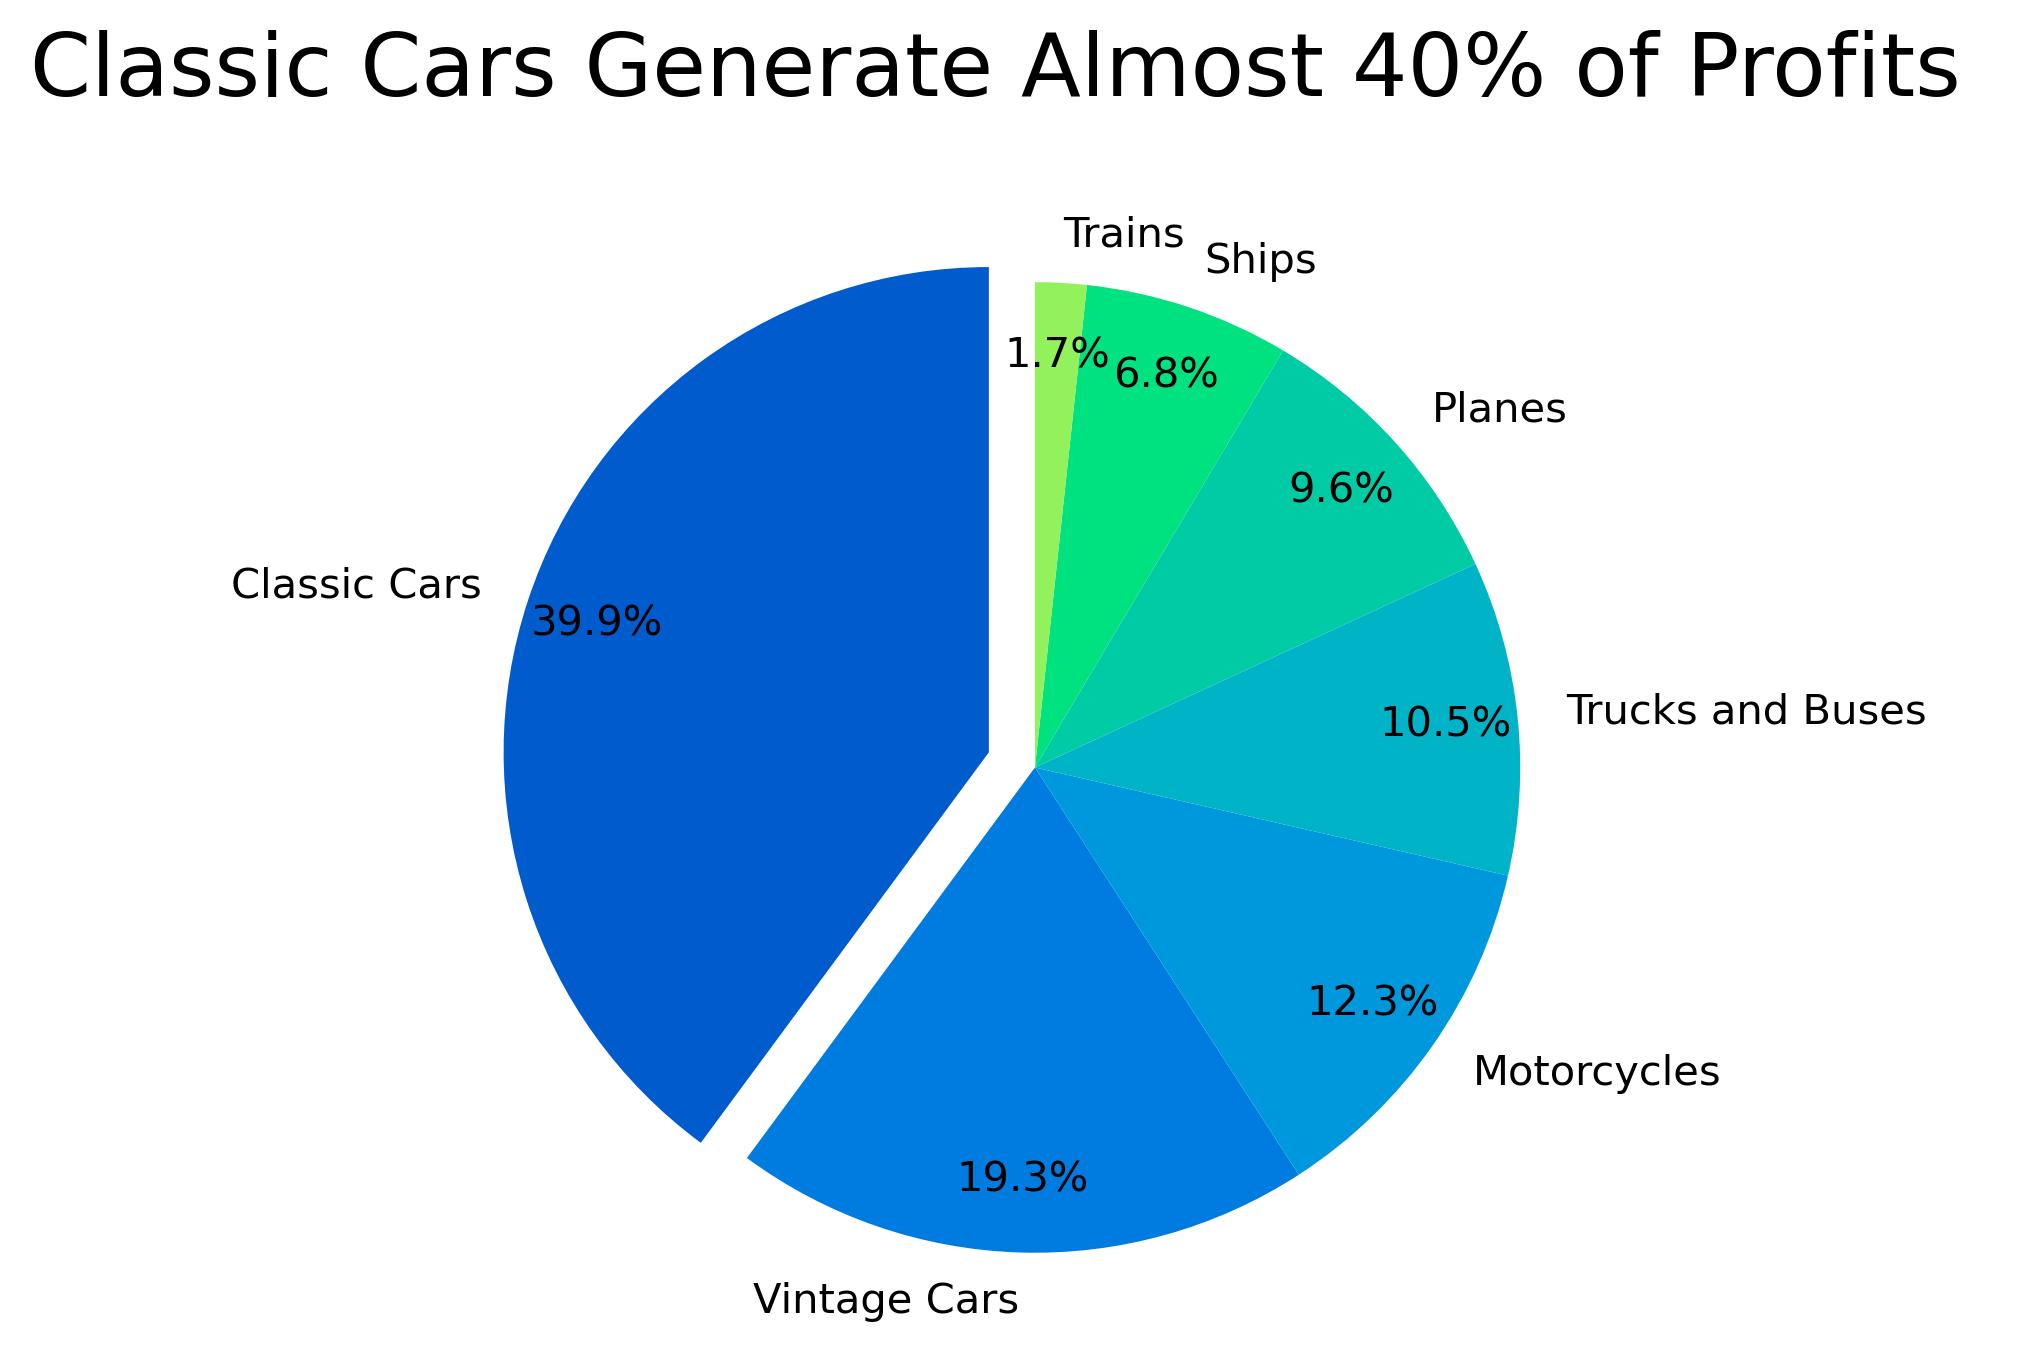

In [15]:
product_line_profit = pd.read_sql_query(
"""SELECT products.productLine AS Product_Category,
     ROUND(SUM((orderdetails.priceEach - products.buyPrice) * orderdetails.quantityOrdered), 2) AS Profits_by_Category,
     ROUND((SUM((orderdetails.priceEach - products.buyPrice) * orderdetails.quantityOrdered) * 100.0 / 
                                                                              (SELECT SUM(profit)
                                                                               FROM customer_profit_report)), 2) AS Percentage
   FROM orderdetails
   JOIN products
     ON orderdetails.productCode = products.productCode
   GROUP BY Product_Category
   ORDER BY Profits_by_Category DESC;""", conn
)

# plot a pie chart
labels = product_line_profit['Product_Category']
sizes = product_line_profit['Percentage']
explode = (0.1, 0, 0, 0, 0, 0, 0)
colors = ['#005bcc','#007bdf','#0098dc','#00b3c6', '#00cba5','#00e17f','#93f25c'] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, colors = colors, autopct='%1.1f%%', startangle = 90, pctdistance=0.85, explode = explode)

# draw circle
centre_circle = plt.Circle((0,2), 0.60, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
ax1.set_title('Classic Cars Generate Almost 40% of Profits \n', size = 21)
plt.show()

**Insights:**
- As previously mentioned, Classic Cars are the most popular product line, whereas Trains are the least popular.
- Vintage Cars represents about one-fifth of the company's overall earnings.

[Index](#Index)

# 8

## Monthly Profits Performance
**Analysis of Profits During a Two-Year Period**

Monthly sales performance may be evaluated from a variety of angles. One of the ways is to look at it from a sales viewpoint, such as the number of individual orders handled on a monthly basis or the sum of all orders processed each month.

Nevertheless, because the main thing is performance, let's concentrate on monthly sales performance based on profits generated each month. The more the earnings for a month, the better the month; a loss signifies a bad month.

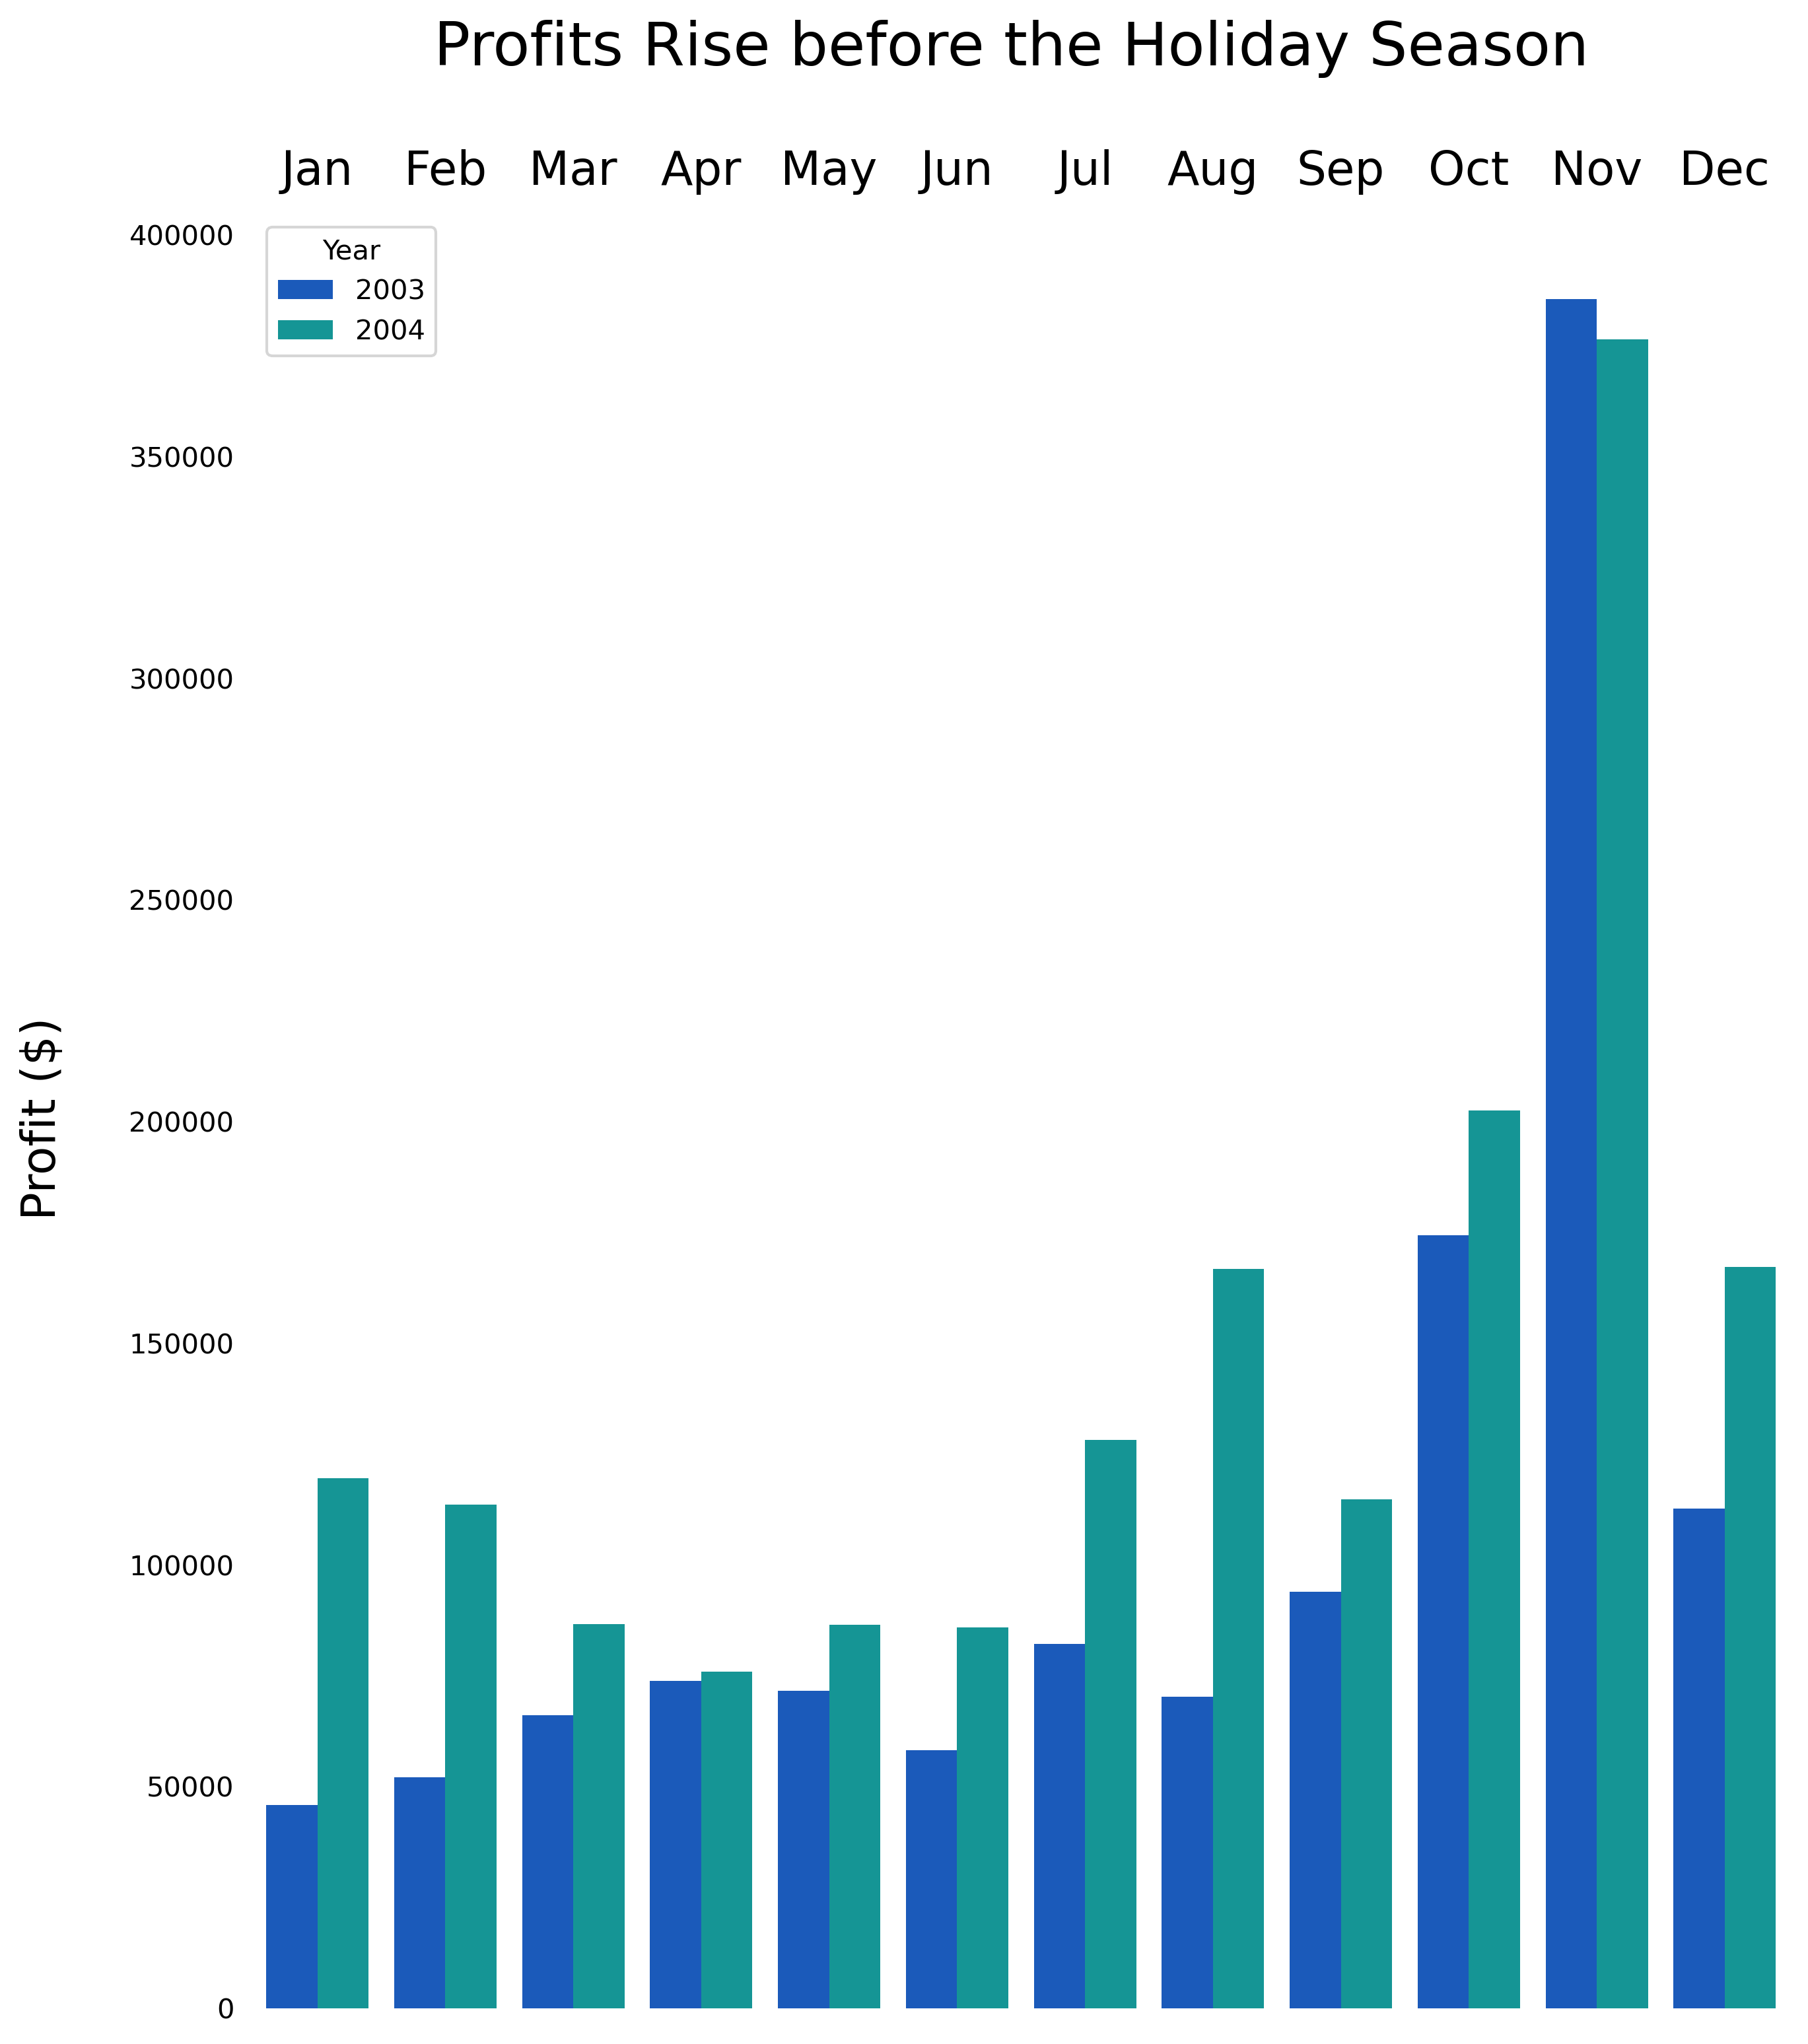

In [16]:
# profit by month and year
monthly_profit_report = pd.read_sql_query(
"""SELECT CAST(SUBSTR(orderDate, 1, 4) AS INT) * 100 + CAST(SUBSTR(orderDate, 6, 7) AS INT) AS Year_Month,
     CAST(SUBSTR(orderDate, 1, 4) AS INT) AS Year,
     CAST(SUBSTR(orderDate, 6, 7) AS INT) AS Month,
     ROUND(SUM(Order_Profit), 2) AS Profit
   FROM shipped_orders
   GROUP BY Year_Month
   HAVING Year_Month < 200501""", conn
)

plt.figure(figsize= (10, 12))


# plot a barplot
ax = sns.barplot(x = 'Month', 
                 y = 'Profit',
                 hue = 'Year',
                 data = monthly_profit_report,
                 palette = 'winter', 
                 orient = 'v',
                 )

# remove spines and set ticks
ax.xaxis.tick_top()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# modify plot
ax.tick_params(left = False, bottom = False, top = False, labelbottom = False)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr',
                    'May', 'Jun', 'Jul', 'Aug',
                    'Sep', 'Oct', 'Nov', 'Dec'], size = 17)
ax.set_xlabel(None)
ax.set_ylabel('Profit ($) \n', size = 17)

ax.set_title('Profits Rise before the Holiday Season \n', size = 22, loc = 'center')
plt.show()
plt.rcParams['figure.dpi'] = 300

**Insights**:
- The company didn't incur any losses between 2003 and 2004.
- Profits in 2003 never exceeded \$100,000 a month until just before the holidays, when the company more than doubled their monthly average earnings from November through December.
- 2004 was a significantly better year than 2003 was. Profits skyrocketed to almost $100,000 right away, dipped slightly in the months that followed, and then climbed much higher throughout the holiday season. However, it should be noted that November sales were slightly lower than in 2003. However, the profits gained in December 2004 more than offset that loss.
- In light of earnings of \$3,000,000 over two years, the overall performance between 2003 and 2004 appears to be pretty strong.
- This estimate, however, has to be cautiously interpreted because it does not account for additional operating expenses that could have been spent over the same time period due to a lack of data.

[Index](#Index)

# 9

## Salesmen Perfomance
**Evaluating Performance of Salesforce**

Vehicle Models intends to increase the size of their sales team, but they first want to assess the effectiveness of their present employees. They have recently seen a decline in the number of new clients and think that it may be related to the sales team's performance.

In [17]:
%%sql
--# join customers, employees and offices
SELECT e.lastName ||', '|| e.firstName AS Sales_Rep_Name,
    o.territory AS Territory,
    o.city AS City,
    SUM(customer_profit_report.no_of_orders) AS No_of_Orders,
    ROUND(SUM(customer_profit_report.profit) / SUM(customer_profit_report.no_of_orders), 2) AS Profit_per_Order,
    ROUND(SUM(customer_profit_report.profit), 2) AS Profit,
    ROUND((SUM(customer_profit_report.profit) * 100.0 / 
              (SELECT SUM(profit) FROM customer_profit_report)), 2) AS Percentage
FROM customers c
JOIN customer_profit_report
  ON c.customerNumber = customer_profit_report.customer_id
JOIN employees e
  ON c.salesRepEmployeeNumber = e.employeeNumber
JOIN offices o
  ON e.officeCode = o.officeCode
GROUP BY e.employeeNumber
ORDER BY Profit DESC;

 * sqlite:///stores.db
Done.


Sales_Rep_Name,Territory,City,No_of_Orders,Profit_per_Order,Profit,Percentage
"Hernandez, Gerard",EMEA,Paris,337,1264.92,426277.05,12.05
"Jennings, Leslie",NA,San Francisco,317,1292.71,409790.22,11.58
"Castillo, Pamela",EMEA,Paris,248,1257.53,311868.46,8.82
"Bott, Larry",EMEA,London,222,1227.71,272552.33,7.7
"Jones, Barry",EMEA,London,198,1275.34,252518.1,7.14
"Vanauf, George",NA,NYC,185,1285.67,237848.82,6.72
"Bondur, Loui",EMEA,Paris,177,1327.07,234891.07,6.64
"Marsh, Peter",APAC,Sydney,166,1243.39,206402.09,5.83
"Fixter, Andy",APAC,Sydney,167,1208.86,201879.08,5.71
"Tseng, Foon Yue",NA,NYC,142,1372.11,194839.92,5.51


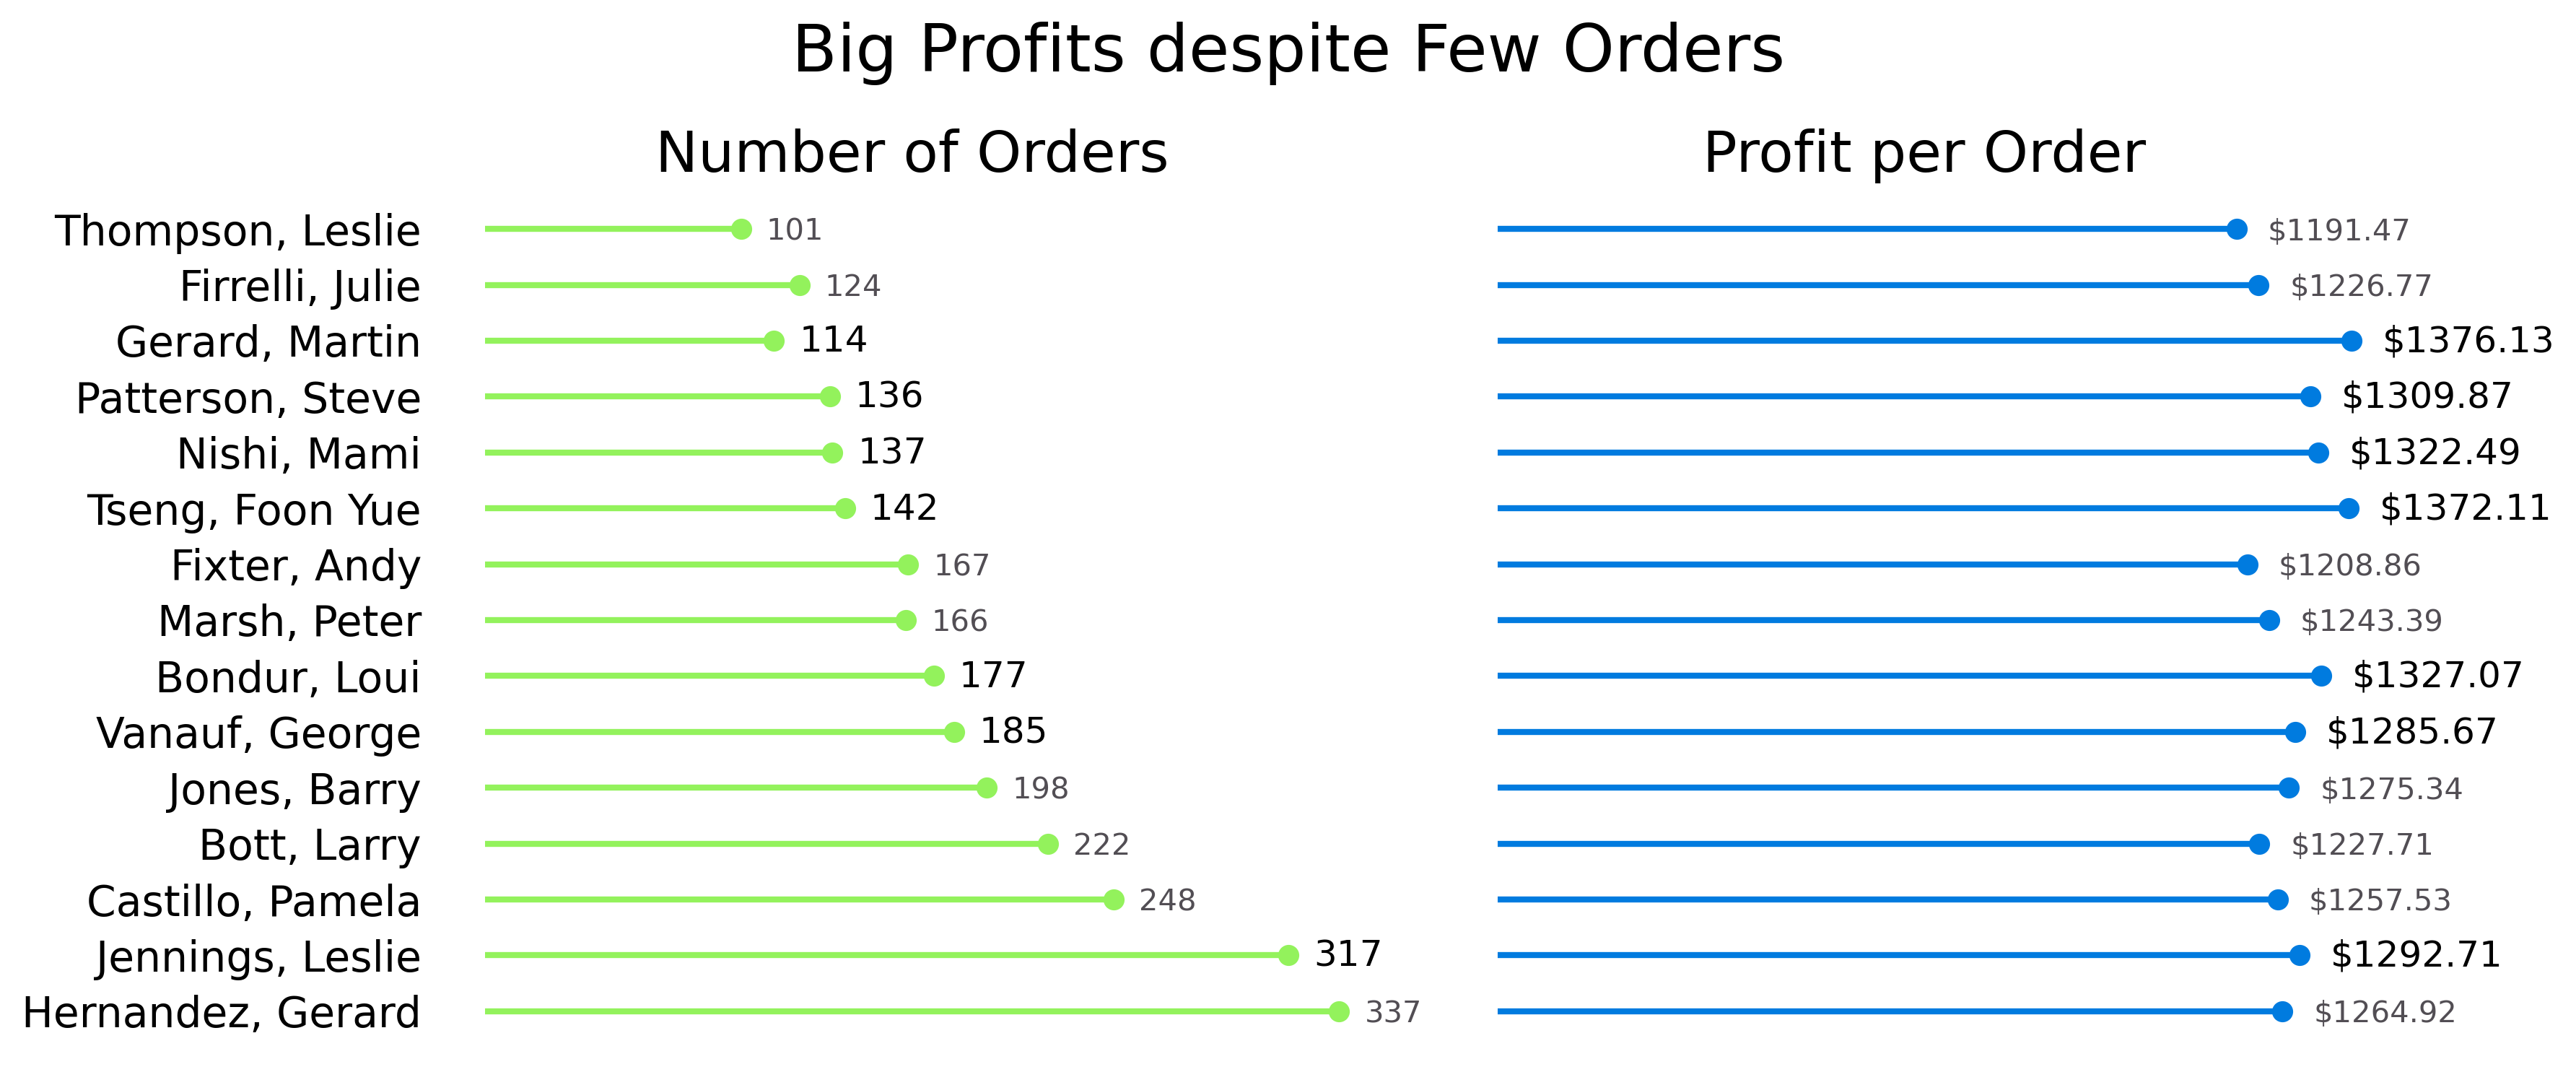

In [18]:
sales_rep_performance_report = pd.read_sql_query(
"""SELECT e.lastName ||', '|| e.firstName AS Sales_Rep_Name,
    o.territory AS Territory,
    o.city AS City,
    SUM(customer_profit_report.no_of_orders) AS No_of_Orders,
    ROUND(SUM(customer_profit_report.profit) / SUM(customer_profit_report.no_of_orders), 2) AS Profit_per_Order,
    ROUND(SUM(customer_profit_report.profit), 2) AS Profit,
    ROUND((SUM(customer_profit_report.profit) * 100.0 / 
              (SELECT SUM(profit) FROM customer_profit_report)), 2) AS Percentage
FROM customers c
JOIN customer_profit_report
  ON c.customerNumber = customer_profit_report.customer_id
JOIN employees e
  ON c.salesRepEmployeeNumber = e.employeeNumber
JOIN offices o
  ON e.officeCode = o.officeCode
GROUP BY e.employeeNumber
ORDER BY Profit DESC;
""", conn
)

fig = plt.figure(figsize = (12, 5))

# plot number of orders
ax1 = fig.add_subplot(1, 2, 1)
    
# remove spines
for each_key in ax1.spines.keys():
    ax1.spines[each_key].set_visible(False)
    
# plot
ax1.hlines(y = sales_rep_performance_report['Sales_Rep_Name'],
           xmin = 0,
           xmax = sales_rep_performance_report['No_of_Orders'],
           color = '#93f25c',
           linewidth = 2)
ax1.scatter(y = sales_rep_performance_report['Sales_Rep_Name'],
            x = sales_rep_performance_report['No_of_Orders'],
            color = '#93f25c')
    
# modifications
ax1.tick_params(bottom = False, left = False, labelbottom = False, labelsize = 14)
    
# specific values for annotation
good_reps = [sales_rep_performance_report.iloc[i, 0] for i in range(len(sales_rep_performance_report)) if sales_rep_performance_report.iloc[i, 4] > 1280]
size = [12 if sales_rep_performance_report.iloc[i, 0] in good_reps else 10 for i in range(len(sales_rep_performance_report))]
palette = ['black' if sales_rep_performance_report.iloc[i, 0] in good_reps else '#524e54' for i in range(len(sales_rep_performance_report))]

# general annotations
for i in range(len(sales_rep_performance_report)):
    ax1.text(s = str(sales_rep_performance_report.iloc[i ,3]),
             x = sales_rep_performance_report.iloc[i, 3] + 10,
             y = i - 0.2,
             size = size[i],
             color = palette[i])
ax1.set_title('Number of Orders', size = 19, loc = 'center')

#---------------------#

# plot profit per order
ax2 = fig.add_subplot(1, 2, 2)

# remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)
    
# plot
ax2.hlines(y = sales_rep_performance_report['Sales_Rep_Name'],
           xmin = 0,
           xmax = sales_rep_performance_report['Profit_per_Order'],
           color = '#007bdf',
           linewidth = 2)
ax2.scatter(y = sales_rep_performance_report['Sales_Rep_Name'],
            x = sales_rep_performance_report['Profit_per_Order'],
            color = '#007bdf')

# modifications
ax2.tick_params(bottom = False, left = False,
                labelbottom = False, labelleft = False)
    
# specific values for annotation
size = [12 if sales_rep_performance_report.iloc[i, 4] > 1280 else 10 
        for i in range(len(sales_rep_performance_report))]
palette = ['black' if sales_rep_performance_report.iloc[i, 4] > 1280 else '#524e54' 
           for i in range(len(sales_rep_performance_report))]

# general annotations
for i in range(len(sales_rep_performance_report)):
    ax2.text(s = '$' + str(sales_rep_performance_report.iloc[i, 4]),
             x = sales_rep_performance_report.iloc[i, 4] + 50,
             y = i - 0.2,
             size = size[i],
             color = palette[i])
ax2.set_title('Profit per Order', size = 19, loc = 'center')

#---------------------#

plt.suptitle('Big Profits despite Few Orders', size = 22, x = 0.50)
plt.tight_layout()
plt.show()

**Insights:**
- Although Gerard Hernandez eventually received the most orders and revenue, the average profit per order is relatively lower.
- Martin Gerarad, on the other hand, has made a smaller profit and showed fewer purchases. It should be mentioned, the profit per order is, nonetheless, the largest of all the salesmen. 
- Compared to their American and Japanese colleagues, salespeople in the European region do better overall in terms of sales. 4 of the top 5 salespeople are from the Europe, in fact. Martin Gerard is also from the European region and has the highest profit per order, as mentioned earlier.

In [19]:
%%sql
--# profits earned by salesman
WITH sales_performance AS(
SELECT employees.lastName ||', '|| employees.firstName AS Sales_Rep_Name, offices.territory AS Territory, offices.city,
       SUM(customer_profit_report.no_of_orders) AS No_of_Orders,
       ROUND(SUM(customer_profit_report.profit) / SUM(customer_profit_report.no_of_orders), 2) AS Profit_per_Order,
       ROUND(SUM(customer_profit_report.profit), 2) AS Profit_Earned,
       ROUND((SUM(customer_profit_report.profit) * 100.0 / 
                          (SELECT SUM(profit)
                           FROM customer_profit_report)), 2) AS Percentage
FROM customers
JOIN customer_profit_report
  ON customers.customerNumber = customer_profit_report.customer_id
JOIN employees
  ON customers.salesRepEmployeeNumber = employees.employeeNumber
JOIN offices
  ON employees.officeCode = offices.officeCode
GROUP BY employees.employeeNumber
ORDER BY Profit_Earned DESC
)

SELECT territory,
       ROUND(AVG(No_of_Orders), 2) AS Number_of_Orders,
       ROUND(AVG(Profit_per_Order), 2) AS Profit_Per_Order
FROM sales_performance
GROUP BY territory
ORDER BY Number_of_Orders DESC;

 * sqlite:///stores.db
Done.


Territory,Number_of_Orders,Profit_Per_Order
EMEA,216.0,1288.12
NA,167.5,1279.77
APAC,166.5,1226.13
Japan,137.0,1322.49


**Insights:**
- To conclude, the European territory generates significantly more orders than all other areas.

[Index](#Index)

# 10

## New Clients
**Determining the Need for Budget Allocation to Acquire New Clients**

In [20]:
%%sql
WITH
--# set date to year_month format in payments
payment_year_month AS(
SELECT *, 
  CAST(SUBSTR(paymentDate, 1, 4) AS INTEGER) * 100 + CAST(SUBSTR(paymentDate, 6, 7) AS INTEGER) AS year_month
FROM payments
),

--# count number of clients for each month and the overall sales for the month
monthly_payment_report AS(
SELECT year_month,
  COUNT(DISTINCT customerNumber) AS number_of_customers,
  SUM(amount) AS monthly_total
FROM payment_year_month
GROUP BY year_month
),

--# count the number of new clients and the total revenue they brought in
new_customers_report AS(
SELECT year_month AS Month,
  COUNT(DISTINCT customerNumber) AS number_of_new_customers,
  SUM(amount) AS new_customer_monthly_total,
       (SELECT number_of_customers
        FROM monthly_payment_report
        WHERE year_month = p1.year_month) AS total_customers_that_paid,
    
       (SELECT monthly_total
        FROM monthly_payment_report
        WHERE year_month = p1.year_month) AS total_amount_paid
FROM payment_year_month p1
WHERE customerNumber NOT IN (SELECT customerNumber
                             FROM payment_year_month p2
                             WHERE p2.year_month < p1.year_month)
GROUP BY year_month
)

--# calculate the new clients and their total sales contributions by percentage for each month 
SELECT Month,
       ROUND(number_of_new_customers * 100 / total_customers_that_paid) AS Percentage_New_Customers,
       ROUND(new_customer_monthly_total * 100 / total_amount_paid) AS Percentage_Paid_by_New_Customers
FROM new_customers_report

 * sqlite:///stores.db
Done.


Month,Percentage_New_Customers,Percentage_Paid_by_New_Customers
200301,100.0,100.0
200302,100.0,100.0
200303,100.0,100.0
200304,100.0,100.0
200305,100.0,100.0
200306,100.0,100.0
200307,75.0,68.0
200308,66.0,54.0
200309,80.0,96.0
200310,69.0,69.0


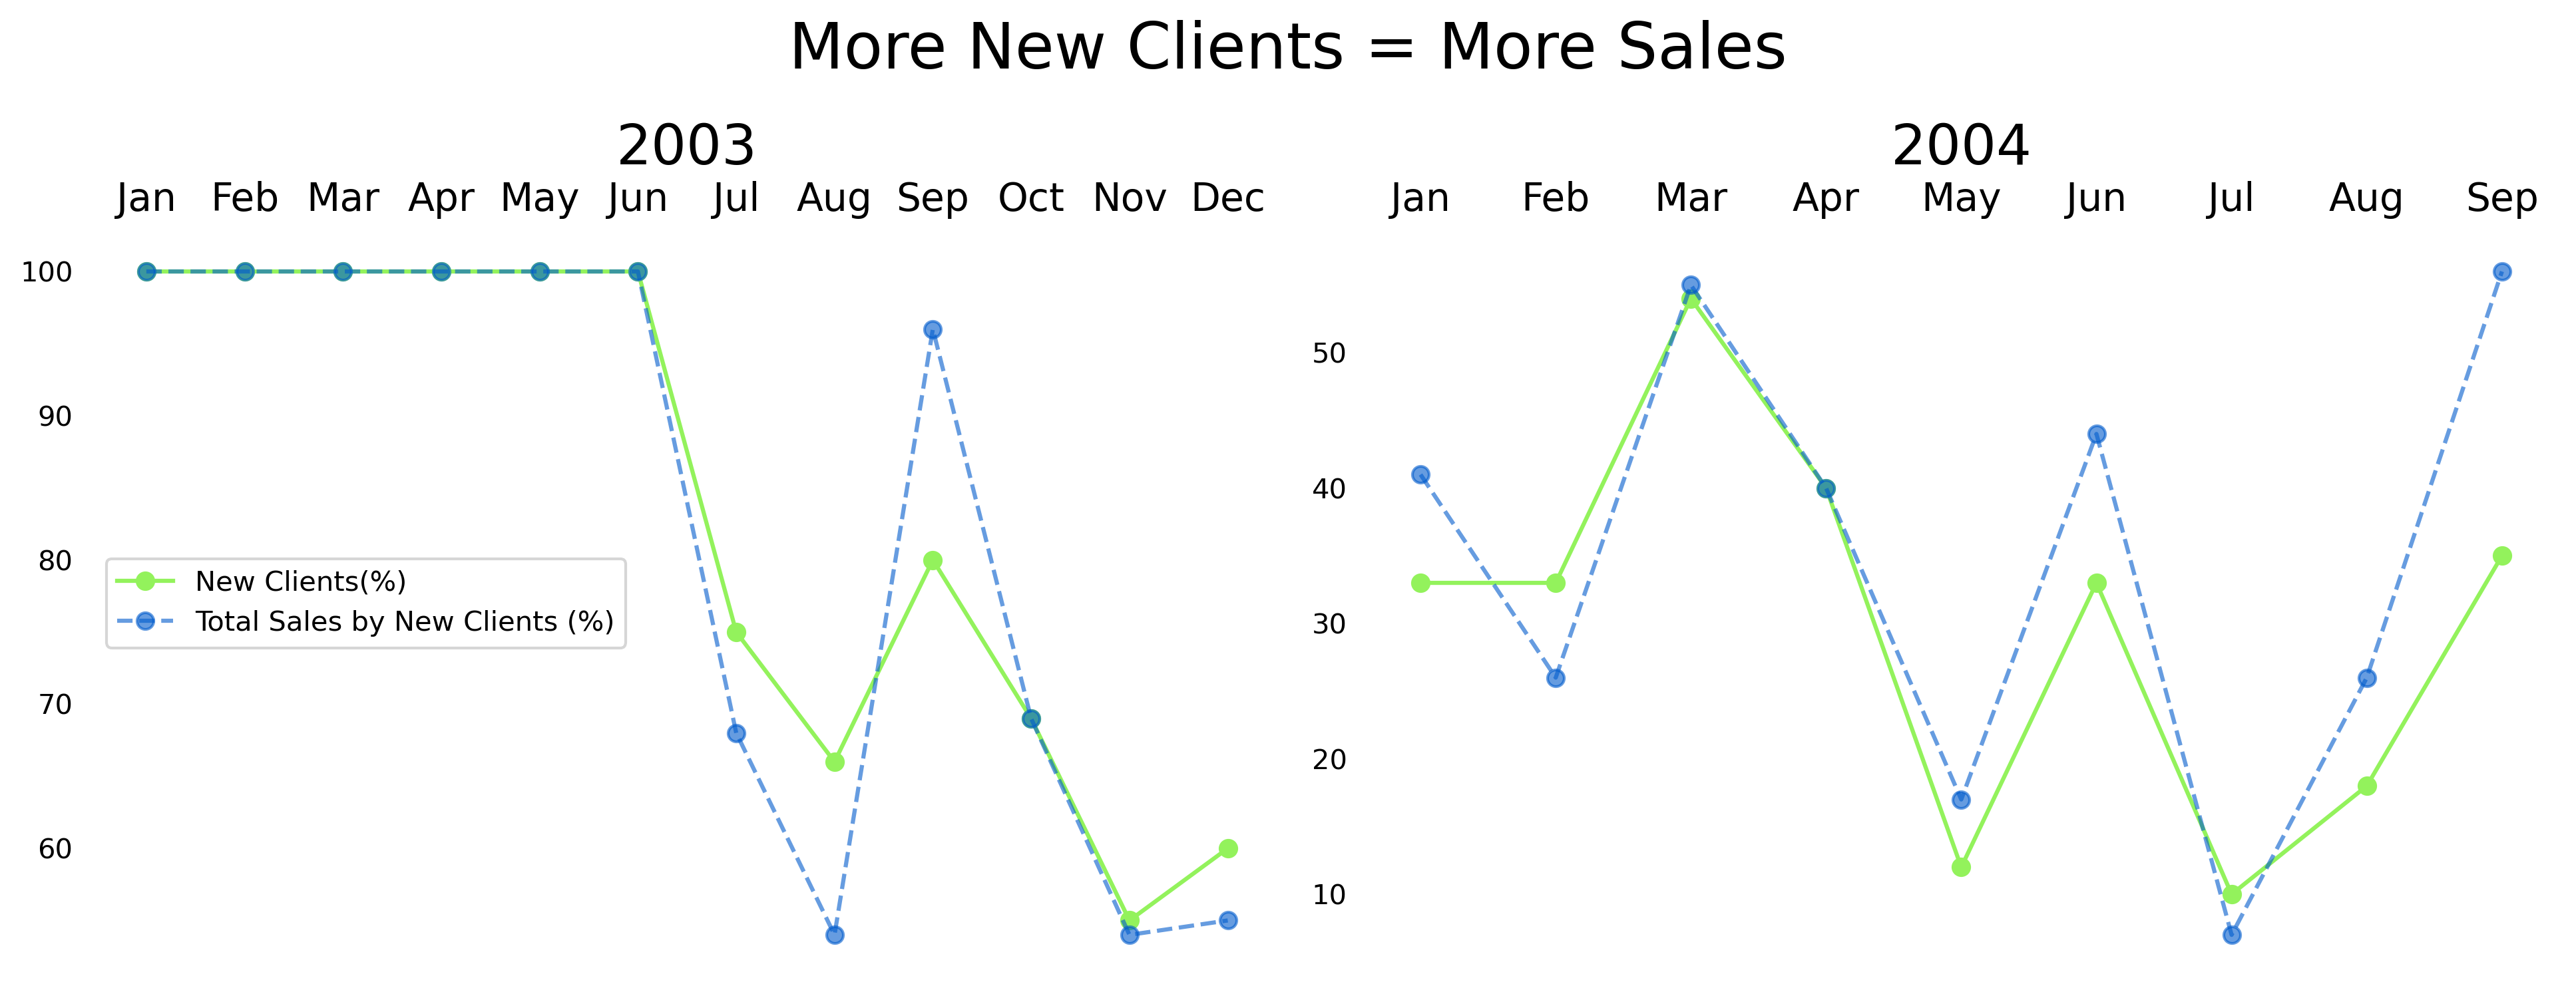

In [21]:
new_customer_report = pd.read_sql_query(
'''WITH
--# set date to year_month format in payments
payment_year_month AS(
SELECT *, 
  CAST(SUBSTR(paymentDate, 1, 4) AS INTEGER) * 100 + CAST(SUBSTR(paymentDate, 6, 7) AS INTEGER) AS year_month
FROM payments
),

--# count number of clients for each month and the overall sales for the month
monthly_payment_report AS(
SELECT year_month,
  COUNT(DISTINCT customerNumber) AS number_of_customers,
  SUM(amount) AS monthly_total
FROM payment_year_month
GROUP BY year_month
),

--# count the number of new clients and the total revenue they brought in
new_customers_report AS(
SELECT year_month AS Month,
  COUNT(DISTINCT customerNumber) AS number_of_new_customers,
  SUM(amount) AS new_customer_monthly_total,
       (SELECT number_of_customers
        FROM monthly_payment_report
        WHERE year_month = p1.year_month) AS total_customers_that_paid,
    
       (SELECT monthly_total
        FROM monthly_payment_report
        WHERE year_month = p1.year_month) AS total_amount_paid
FROM payment_year_month p1
WHERE customerNumber NOT IN (SELECT customerNumber
                             FROM payment_year_month p2
                             WHERE p2.year_month < p1.year_month)
GROUP BY year_month
)

--# calculate the new clients and their total sales contributions by percentage for each month 
SELECT Month,
       ROUND(number_of_new_customers * 100 / total_customers_that_paid) AS Percentage_New_Customers,
       ROUND(new_customer_monthly_total * 100 / total_amount_paid) AS Percentage_Paid_by_New_Customers
FROM new_customers_report''',conn
)

# plot 2003 data
data1 = new_customer_report[new_customer_report['Month'].between(200301, 200312)]
fig = plt.figure(figsize = (13, 5))

ax1 = fig.add_subplot(1, 2, 1)

# remove spines
for each_key in ax1.spines.keys():
    ax1.spines[each_key].set_visible(False)

# x axis to the top
ax1.xaxis.tick_top()
ax1.tick_params(bottom = False, left = False, top = False, labeltop = True)

# modifications
ax1.set_xticks(data1['Month'])
months= ['Jan', 'Feb', 'Mar', 'Apr',
         'May', 'Jun', 'Jul', 'Aug',
         'Sep', 'Oct', 'Nov', 'Dec']
ax1.set_xticklabels(months, size = 14)

# plot
plt.plot('Month',
         'Percentage_New_Customers',
         data = data1, marker = 'o', color = '#93f25c', label = 'New Clients(%)')

plt.plot('Month','Percentage_Paid_by_New_Customers',
         data = data1, marker='o', color = '#005bcc', linestyle = '--', alpha = 0.6, label = "Total Sales by New Clients (%)")
ax1.legend(loc = 'center left')
ax1.set_title('2003', size = 20, loc = 'center')

#---------------------#

# plot 2004 data
data2 = new_customer_report[new_customer_report['Month'].between(200401, 200412)]
ax2 = fig.add_subplot(1, 2, 2)

# remove spines
for each_key in ax2.spines.keys():
    ax2.spines[each_key].set_visible(False)

# x axis to the top
ax2.xaxis.tick_top()
ax2.tick_params(bottom = False, left = False, top = False, labeltop = True, labelleft = True)

# modifications
ax2.set_xticks(data2['Month'])
months2 = ['Jan', 'Feb', 'Mar', 'Apr',
           'May', 'Jun', 'Jul', 'Aug', 'Sep']
ax2.set_xticklabels(months2, size = 14)

# plot
plt.plot('Month', 'Percentage_New_Customers', data = data2, marker = 'o', color = '#93f25c')
plt.plot('Month', 'Percentage_Paid_by_New_Customers', 
         data = data2 ,marker = 'o', color = '#005bcc', linestyle = '--', alpha = 0.6)
ax2.set_title('2004', size = 20, loc = 'center')

#---------------------#

plt.suptitle('More New Clients = More Sales', size = 23, x = 0.50)
plt.tight_layout()
plt.show()

**Insights:**
- Clearly, the number of new clients affects sales. In certain cases, the impact of new clients on sales appears exponential. This is illustrated particularly in August and September of 2003, and February and June of 2004.
- January and February of 2004 stand out as an outlier, as sales increased and then decreased while having the same percentage of new customers for both months. It's possible that this was due to the fact that the year had just begun.
- There have been no new clients since September 2004, which is a concerning indicator for 2005.

[Index](#Index)

# 11

## Dead Stock
**Identifying Which Items Were Not Sold Out**

[Dead stock](https://dictionary.cambridge.org/us/dictionary/english/dead-stock) refers to items that have not been sold in a very long period. They frequently represent a cost due to the amount of space they occupy. These items might not be sold at all, which will result loss.

In this section, let's identify any particular items that haven't been sold in a year and their associated costs.

In [22]:
%%sql
WITH
orders_year_month AS(
SELECT *, 
  CAST(SUBSTR(orderDate, 1, 4) AS INTEGER) * 100 + CAST(SUBSTR(orderDate, 6, 7) AS INTEGER) AS year_month
FROM orders
),

last_six_months_orders AS(
SELECT DISTINCT orderdetails.productCode
FROM orderdetails
JOIN orders_year_month
  ON orderdetails.orderNumber = orders_year_month.orderNumber
WHERE orders_year_month.year_month BETWEEN 200405 AND 200505
)

SELECT products.productName AS Product, products.quantityinStock AS Stock_Quantity,
  ROUND(products.buyPrice * products.quantityinStock, 2) AS Cost
FROM products
WHERE productCode NOT IN (SELECT productCode
                          FROM last_six_months_orders);

 * sqlite:///stores.db
Done.


Product,Stock_Quantity,Cost
1985 Toyota Supra,7733,440858.33


**Insights:**
- For a year, there was no demand for 1985 Toyota Suppra. It also comes at a great expense incurred.

[Index](#Index)

# 12

## Recommendations

The suggestions based on the information received after analyzing the data in response to the questions posed by the Vehicle Model Company are listed below.

**Clients:**
- Concentrate on encouraging current customers to make larger purchases because, at the moment, monthly sales appear to be more dependent on the acquisition of new clients, which may be an expensive investment.
- Loyal customers should be rewarded. If there isn't already a loyalty program, it might be a wise idea to establish one. It will attract larger orders and guarantee continuous business.
- Focus on attracting new consumers to maintain the monthly sales figures until the company can persuade existing customers to make larger purchases. According to the data, it was discovered that since September 2004, there have been no new clients, which is concerning because they are responsible for a large portion of the present revenues.

**Salesmen:**
- Sales representatives appear to be performing well overall. However, to performe even better, they should start encouraging clients to make larger purchases, which boosts revenues on each order.
- Along with boosting client orders, sales representatives need to be driven to persuade customers in their territory to purchase more items in a single order.
- Sales representatives in the US need to perform better to increase consumer confidence in their area. Given that there are several zonal offices in the area and that market intelligence is easily accessible, the sales staff ought to be able to determine what is preventing their consumers from making larger purchases. Given that regional sales are significantly lower than those in the European region, this recommendation is being made.

**Existing and Potential Markets:**
- Asia-Pacific region markets appear to be underdeveloped. There are probably many buyers eager to spend money on models, at least as a hobby, given the advancement of technology and a market boom.
- Consideration of major market growth into Europe would be a wise investment. Many European countries, like Spain, Norway, and Switzerland, have the resources and are prepared to pay more for each order. For Asian markets like Singapore, the same is valid.

**Products:**
- Classic and Vintage car models are the most popular product categories. To boost the value of these models and generate demand, it would be useful to link them to a relevant history.
- To better understand why some product lines are not as popular, it would be wise to introduce new categories in addition to the ones already present for the product line. Although it's true that Trains are the least popular, this may not apply to all train-related items. Improved sub-categorization, based on the model's production year or date, could help determine how buyers feel about it.
- Although it is helpful to know that there is just one product that qualifies as deadstock, it's not wise to continue hanging onto it given the hit to earnings it is causing. Action must be done against the product as soon as possible; else, the loss from damage might be significant.
- The company should take into account additional product categories outside model vehicles, such as stickers, toys, etc., that might help in business expansion.

**Overall:**
- Prior to actually implementing this, the Marketing and Finance teams should review this report. Any assumptions made in this report were done without feedback from these departments, thus some of them might not be accurate. For instance, the net revenue for the years 2003 and 2004 is just little over \$3,000,000. This estimate does not account for overhead expenses like fees, replacement prices, refunds, etc.

- More data should be gathered in the future for better analysis. The following information might be useful:
    - Data on overhead expenses for each order, including fees and discounts.
    - Data on credits or refunds for defective products.
    - Data on customer-end purchases to determine how the end client interacts with the offering. By demonstrating end-user behavior, this data may enable the company's sales representatives to encourage clients to make larger purchases.

[Index](#Index)

# 13

## Conclusion

Vehicle model collecting is a hobby and, as a result, selling them might be quite challenging. Vehicles Models Company is a fictitious company that specialized in this endeavor. In this project, I was expected to analyze their database and acquire information on questions and concerns they had about their business.

I did analyze their data and was able to gather insights. Based on what can be seen, the business has a positive outlook overall. They're able to generate constant revenues, and their salespeople perform an excellent job of ensuring that their profit stream is robust. While their present market options are limited, they have tremendous opportunities to develop and grow, as indicated in the recommendations section. I have also recommended that the company collect additional data about other aspects of the business which should help us in better data analysis in the future.